In [1]:
from tensorflow.python.keras.layers import Input, Dense, LSTM, Dropout, Convolution2D, MaxPooling2D, Activation, Flatten   

from tensorflow.python.keras.models import Sequential
import tensorflow as tf
from keras.utils import plot_model
from keras.optimizers import SGD, Adam
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
import datetime as dt
import pandas_datareader as pdr
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
register_matplotlib_converters()
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import bollinger_pband
import seaborn as sns
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import sklearn.preprocessing as prep
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
from datetime import datetime
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
yf.pdr_override()

C:\Users\Parth\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Parth\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Parth\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
def get_exp_preprocessing(df):
    edata = df.ewm(alpha=0.9).mean()   
    return edata

In [3]:
def preprocesses(data):
    data['pred'] = data['Adj Close']
    predList = []
    y = 0
    for i in data['pred']:
        predList.append(i)

    while y < data.shape[0] -1 :
        diff = predList[y] - predList[y+1]
        if diff > 0:
            predList[y] = 0
        else:
            predList[y] = 1
        y += 1

    data['pred'] = predList

#     data['pred'] = np.where(data['Adj Close'].shift(-1) > data['Adj Close'],1,0)
#     data['Log_Ret_1d']=np.log(data['Close'] / data['Close'].shift(1))

#     data['Return_Label']=pd.Series(data['Log_Ret_1d']).shift(-21).rolling(window=21).sum()
#     data['pred']=np.where(data['Return_Label'] > 0, 1, 0)
#     del data['Return_Label']

    return data

In [4]:
def drop_cols(data, pct):
    data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    #data = data[['volume_em', 'momentum_rsi', 'volatility_bbp', 'Adj Close','pred']]
    #data = data[['Adj Close','pred']]
    data = data[['volume_em', 'momentum_rsi', 'volatility_bbp','Adj Close','pred']]
    first = True
    if pct == True:
        for col in data.columns:
            if col != 'pred' and first == False:
                data[col] = data[col].pct_change()
            else:
                first = False
                
    data = data.dropna()
    cols = []
    for col in data.columns:
        if col != 'pred':
            cols.append(col)
    return data, cols

In [33]:
def prepare_data(data):
    del (data['pred'])
    data = data.dropna()
    return data
    
def split_x_y(data_final, close_vals):
    #Y = data_final['pred'].values
    train_scaled = prepare_data(data_final)
    train_scaled = train_scaled.iloc[1: , :]
    close_vals = close_vals.iloc[1:]
    #Y = Y[:-1]
    Y = []
    X = []
    for i in range (0, len(train_scaled) - 3, 3):
        x_seq = train_scaled[i:i+3]
        if (close_vals[i+2] < close_vals[i] ):
            y_seq = 0
        else: 
            y_seq = 1
        X.append(x_seq)
        Y.append(y_seq)
        
        
        
    return X, Y

In [6]:
def scaler(train_scaled):
    min_max = MinMaxScaler((0, 1))
    train_scaled = min_max.fit_transform(train_scaled)
    return train_scaled

In [7]:
def split_train_test(train_scaled, Y):
    factor = 0.80

    length = train_scaled.shape[0]

    total_for_train = int(length*factor)

    X_train = np.array(train_scaled[:total_for_train])
    Y_train = np.array(Y[:total_for_train])
    X_test = np.array(train_scaled[total_for_train:])
    Y_test = np.array(Y[total_for_train:])
    
    return X_train, Y_train, X_test, Y_test

In [8]:
# cur shape = (5844, 1, 4)
# new shape 

In [9]:
def reshape_3d(X_train,X_test):
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1] ))
    return X_train, X_test

In [49]:
import keras 

def build_model(X_train, Y_train,X_test, Y_test):
#     model=Sequential()
#     model.add(tf.keras.layers.LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
#     model.add(tf.keras.layers.LSTM(100,return_sequences=True))
#     model.add(tf.keras.layers.LSTM(100,return_sequences=True))
#     model.add(tf.keras.layers.LSTM(100,return_sequences=True))
#     #multitask learning
#     #LSTM = ...
#     #up_down_pred = tf.dense(1, activation = 'sigmoid')(LSTM)
#     #diff_pred = tf.dense(1, activation = None)(LSTM)
    
#     model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
#     opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#     model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

#     history=model.fit(X_train,Y_train,batch_size=64,epochs=100, validation_data=(X_test,Y_test))
   
#     return model

    inputs = keras.Input(shape = (X_train.shape [1], X_train.shape [2]))
    x= keras.layers.LSTM(units = 100, return_sequences=True )(inputs)
    x= keras.layers.LSTM(units = 100, return_sequences=True )(x)
    x= keras.layers.LSTM(units = 100, return_sequences=False ) (x)
    #x= keras.layers.Dropout(0.2)(x)
    #x=keras.layers.Dense(units = 32, activation = 'relu')(x)
    #x= keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(units = 1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="Adam", loss="binary_crossentropy",  metrics = ['acc'])

    history = model.fit(X_train, Y_train, batch_size = 128, epochs = 100, validation_split=0.15, verbose=2)
    
    return model

In [ ]:
## write optimal lr, Batch, Cells, 

In [54]:
pct = True
start = datetime.strptime('1990-01-01', '%Y-%m-%d')
end = datetime.strptime('2019-1-01', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)
data_smoothed = get_exp_preprocessing(data)
data_processed = preprocesses(data_smoothed)
data_final, cols = drop_cols(data_processed, pct)

close = data_smoothed['Adj Close']
X, Y = split_x_y(data_final, close)

X = np.array(X)

if pct == False:
    X_scaled = scaler(X)
elif pct ==True: 
    X_scaled = X
    
X_train, Y_train, X_test, Y_test = split_train_test(X_scaled,Y)



#X_train, X_test = reshape_3d(X_train, X_test)



model = build_model(X_train, Y_train, X_test, Y_test)


[*********************100%***********************]  1 of 1 completed
Train on 1654 samples, validate on 293 samples
Epoch 1/100
 - 1s - loss: 0.6861 - acc: 0.5828 - val_loss: 0.6732 - val_acc: 0.6416
Epoch 2/100
 - 0s - loss: 0.6477 - acc: 0.6391 - val_loss: 0.6145 - val_acc: 0.7372
Epoch 3/100
 - 0s - loss: 0.5765 - acc: 0.7860 - val_loss: 0.5178 - val_acc: 0.8191
Epoch 4/100
 - 0s - loss: 0.5283 - acc: 0.8108 - val_loss: 0.4678 - val_acc: 0.7986
Epoch 5/100
 - 0s - loss: 0.4828 - acc: 0.8011 - val_loss: 0.4263 - val_acc: 0.8362
Epoch 6/100
 - 0s - loss: 0.4523 - acc: 0.8168 - val_loss: 0.4012 - val_acc: 0.8498
Epoch 7/100
 - 0s - loss: 0.4338 - acc: 0.8241 - val_loss: 0.3875 - val_acc: 0.8430
Epoch 8/100
 - 0s - loss: 0.4192 - acc: 0.8277 - val_loss: 0.3658 - val_acc: 0.8601
Epoch 9/100
 - 0s - loss: 0.4034 - acc: 0.8343 - val_loss: 0.3503 - val_acc: 0.8567
Epoch 10/100
 - 0s - loss: 0.3835 - acc: 0.8392 - val_loss: 0.3151 - val_acc: 0.8771
Epoch 11/100
 - 0s - loss: 0.3506 - acc: 0.

 - 0s - loss: 0.0578 - acc: 0.9746 - val_loss: 0.1915 - val_acc: 0.9181
Epoch 97/100
 - 0s - loss: 0.0637 - acc: 0.9728 - val_loss: 0.1119 - val_acc: 0.9522
Epoch 98/100
 - 0s - loss: 0.0481 - acc: 0.9764 - val_loss: 0.1119 - val_acc: 0.9522
Epoch 99/100
 - 0s - loss: 0.0427 - acc: 0.9819 - val_loss: 0.1214 - val_acc: 0.9488
Epoch 100/100
 - 0s - loss: 0.0404 - acc: 0.9819 - val_loss: 0.1012 - val_acc: 0.9659


In [36]:
Y

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,


In [29]:
data_processed

Open       High        Low      Close  Adj Close        Volume       pred    volume_adi    volume_obv  volume_cmf  ...  momentum_wr  momentum_ao  momentum_kama  momentum_roc  momentum_ppo  momentum_ppo_signal  momentum_ppo_hist  others_dr  others_dlr     others_cr
Date                                                                                                                                ...                                                                                                                                                  
1990-01-02   0.314732   0.334821   0.312500   0.332589   0.266812  1.831984e+08   1.000000  1.465606e+08  1.831984e+08    0.800010  ...    -9.999493     0.000000       0.332589      0.000000      0.000000             0.000000           0.000000 -96.117878    0.000000      0.000000
1990-01-03   0.337054   0.338880   0.332792   0.334618   0.268440  2.057409e+08   1.000000  6.424984e+07  3.889393e+08    0.165192  ...   -16.156167     0.000000       0.333579      0.000000      0.972728             0.194546           0.778183   0.610086    0.608232      0.610086
1990-01-04   0.341076   0.345278   0.332609   0.335807   0.269394  2.199505e+08   1.000000 -4.465491e+07  6.088899e+08   -0.073338  ...   -28.894182     0.000000       0.334613      0.000000      2.304513             0.616539           1.687974   0.355368    0.354738      0.967621
1990-01-05   0.337456   0.341894   0.330582   0.336929   0.270294  1.329672e+08   1.000000 -2.839559e+07  7.418570e+08   -0.038276  ...   -25.470435     0.000000       0.335639      0.000000     -0.377259             0.417780          -0.795038   0.334192    0.333635      1.305048
1990-01-08   0.335084   0.339547   0.330379   0.339050   0.271996  1.047120e+08   0.000000  6.497667e+07  8.465690e+08    0.076753  ...   -18.999914     0.000000       0.337047      0.000000     -3.865472            -0.438871          -3.426601   0.629485    0.627512      1.942748
1990-01-09   0.338866   0.339312   0.330359   0.336249   0.269748  8.799646e+07   0.000000  9.276462e+07  7.585725e+08    0.099260  ...   -27.545612     0.002084       0.336734      0.000000     -7.578687            -1.866834          -5.711853  -0.826168   -0.829600      1.100529
1990-01-10   0.336231   0.336275   0.320312   0.322911   0.259048  1.885462e+08   0.000000 -3.439255e+07  5.700263e+08   -0.030623  ...   -68.237922     0.001402       0.330693      0.000000     -5.549943            -2.603456          -2.946487  -3.966761   -4.047582     -2.909887
1990-01-11   0.324918   0.324922   0.309264   0.309524   0.248308  2.088021e+08   0.000000 -2.362642e+08  3.612242e+08   -0.177387  ...   -99.278424    -0.000948       0.321445      0.000000     -2.957642            -2.674293          -0.283349  -4.145889   -4.234283     -6.935135
1990-01-12   0.307715   0.311733   0.302131   0.308185   0.247234  1.755881e+08   0.000000 -1.904639e+08  1.856361e+08   -0.126344  ...   -85.970463    -0.004109       0.315648      0.000000     -2.473831            -2.634201           0.160369  -0.432521   -0.433459     -7.337660
1990-01-15   0.308004   0.318450   0.305437   0.306042   0.245515  1.631241e+08   1.000000 -3.384118e+08  2.251204e+07   -0.202566  ...   -90.936453    -0.007054       0.311381      0.000000     -2.648627            -2.637086          -0.011541  -0.695252   -0.697681     -7.981897
1990-01-16   0.299997   0.313095   0.293714   0.310850   0.249372  2.091327e+08   0.000000 -1.777316e+08  2.316448e+08   -0.094550  ...   -66.767472    -0.011207       0.311312      0.000000     -0.628557            -2.235380           1.606823   1.570932    1.558721     -6.536355
1990-01-17   0.309241   0.310551   0.294550   0.298272   0.239282  1.984826e+08   0.000000 -2.838636e+08  3.316222e+07   -0.136588  ...   -91.158851    -0.014506       0.308508      0.000000      0.446043            -1.699096           2.145138  -4.046109   -4.130241    -10.317996
1990-01-18   0.296103   0.300251   0.288606   0.289984   0.232633  2.

In [14]:
Y_train

array([1., 1., 1., ..., 1., 0., 0.])

In [33]:
correlation_df = X.corr()
print(correlation_df)


AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [52]:
Y_test

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,

In [55]:
acc = model.evaluate(X_test,Y_test)
y_pred=model.predict(X_test)
rounded = np.round(y_pred)
rounded = rounded.reshape(-1)

487/487 [==============================] - 0s 90us/step


In [42]:
for i in range(50):
    print(Y_test[i], rounded[i])

0 1.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 1.0
1 1.0
1 1.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 1.0


In [36]:
X_train.shape

(5841, 3, 4)

inputs: ['volume_em', 'momentum_rsi', 'volatility_bbp', 'Adj Close']
is data percent change: True
model loss & accuracy: [0.9075644287974928, 0.8870636820793152]


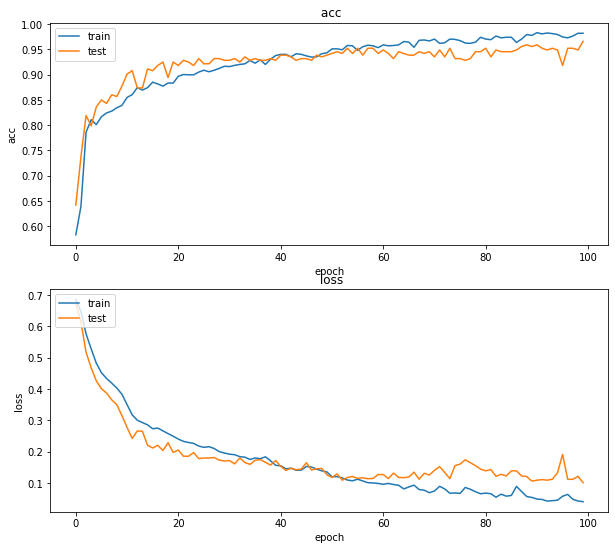

[Text(0, 0.5, 'Down'), Text(0, 1.5, 'Up')]

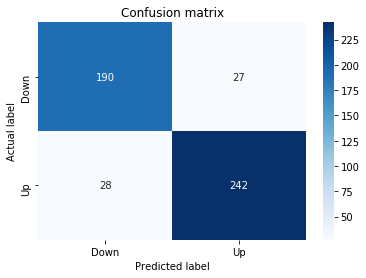

In [56]:

print ("inputs: " + str(cols)) 


print ("is data percent change: " + str(pct))

print ("model loss & accuracy: " + str(acc))

import matplotlib.pyplot as plt  
plt.figure(1, figsize=(10,9) )  

plt.subplot(211)  
plt.plot(model.history.history['acc'])  
plt.plot(model.history.history['val_acc'])  
plt.title(' acc')  
plt.ylabel('acc')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(212)  
plt.plot(model.history.history['loss'])  
plt.plot(model.history.history['val_loss'])  
plt.title(' loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

import sklearn.metrics as metrics
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(Y_test, rounded)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

In [40]:
rounded


array([1., 0., 0., ..., 0., 1., 1.], dtype=float32)

In [41]:
Y_test

array([0, 0, 0, ..., 0, 0, 1])

In [38]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 100)            42000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 100)            80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 100)            80400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 283,301
Trainable params: 283,301
Non-trainable params: 0
_________________________________________________________________


In [53]:
pct = True
start = datetime.strptime('2019-01-01', '%Y-%m-%d')
end = datetime.strptime('2021-8-9', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)
data_smoothed = get_exp_preprocessing(data)
data_processed = preprocesses(data_smoothed)
data_final, cols = drop_cols(data_processed, pct)
X, Y = split_x_y(data_final)
X_train, Y_train, X_test, Y_test = split_train_test(X,Y)

X_train, X_test = reshape_3d(X_train, X_test)


[*********************100%***********************]  1 of 1 completed


In [62]:
model.evaluate(X_train,Y_train)

522/522 [==============================] - 0s 94us/sample - loss: 0.5288 - acc: 0.9195


[0.5288442239286628, 0.9195402]

In [51]:
X.shape

(653, 7)

In [63]:
y_pred=model.predict(X_train)


In [64]:
rounded = np.round(y_pred)


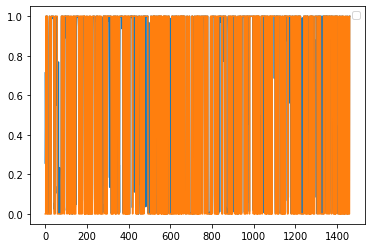

In [39]:
predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = [ '_predict']
result['_actual'] = Y_test

result.plot()
plt.show()
 